# GI Tract Segmentation

Import Libraries

In [1]:
import json
import zipfile
import os

import numpy as np
import pandas as pd
import cv2
from glob import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.data import Dataset

from tensorflow import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

Mount the drive to ensure access to where you store the images on Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load and examine the data

Move mask files to another folder. 

In [3]:

#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
#!echo '{"username":"USERNAME","key":"API_KEY"}' > /root/.kaggle/kaggle.json
#with open('/root/.kaggle/kaggle.json', 'w') as file:
#    json.dump(api_token, file)
#!kaggle competitions download -c uw-madison-gi-tract-image-segmentation

In [4]:
# Unzip Dataset
#zip_ref = zipfile.ZipFile('/content/uw-madison-gi-tract-image-segmentation.zip','r')
#zip_ref.extractall()
#zip_ref.close()

In [5]:
#import shutil

#original = r'/content/train'
#target = r'/content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg'

#shutil.move(original, target)

In [6]:
#os.remove('/content/uw-madison-gi-tract-image-segmentation.zip')

In [7]:
train_dir = "/content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg/train"
train_csv = "/content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg/train.csv"
test_csv = "../content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg/sample_submission.csv"

In [8]:
#load metadata
train_df = pd.read_csv(train_csv)
train_df.sample(5)

,id,class,segmentation
85808,case36_day16_slice_0123,stomach,NaN
37319,case90_day0_slice_0088,stomach,27309 7 27574 11 27839 14 28104 18 28369 21 28...
50378,case147_day14_slice_0121,stomach,NaN
38494,case49_day13_slice_0048,small_bowel,NaN
46269,case154_day17_slice_0048,large_bowel,NaN


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [10]:
print(train_df.shape)

(115488, 3)


In [11]:
test_df = pd.read_csv(test_csv)
test_df.head()

,id,class,predicted


In [12]:
# Test set

if len(test_df) == 0:
  DEBUG = True
  test_df = train_df.iloc[:10*16*3,:]
  test_df["segmentation"] = ''
  test_df = test_df.rename(columns={"segmentation":"predicted"})
else:
  DEBUG=False

results=test_df.copy()
test_df.head()

<ipython-input-12-1beb94218152>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["segmentation"] = ''


,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


In [13]:
def preprocessing(df, subset = "train"):
  df.rename(columns = {'class':'class_name'}, inplace = True)
  #--------------------------------------------------------------------------
  df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
  df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
  df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
  #--------------------------------------------------------------------------
  if (subset == "train") or (DEBUG):
    DIR = "../content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg/train"
  else:
    DIR = "../content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg/test"

  all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
  x = all_images[0].rsplit("/", 4)[0] 

  path_partial_list = []
  for i in range(0, df.shape[0]):
      path_partial_list.append(os.path.join(x,
                            "case"+str(df["case"].values[i]),
                            "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                            "scans",
                            "slice_"+str(df["slice"].values[i])))
  df["path_partial"] = path_partial_list
  #--------------------------------------------------------------------------
  path_partial_list = []
  for i in range(0, len(all_images)):
      path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))
      
  tmp_df = pd.DataFrame()
  tmp_df['path_partial'] = path_partial_list
  tmp_df['path'] = all_images

  #--------------------------------------------------------------------------
  df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
  #--------------------------------------------------------------------------
  df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
  df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
  #--------------------------------------------------------------------------
  del x,path_partial_list,tmp_df
  #--------------------------------------------------------------------------
  return df

In [14]:
train_df = preprocessing(train_df, subset="train")
train_df.head()

,id,class_name,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../content/drive/MyDrive/Projects/Image_Segmen...,266,266


In [15]:
test_df = preprocessing(test_df, subset="test")
test_df.sample(10)

,id,class_name,predicted,case,day,slice,path,width,height
474,case123_day22_slice_0015,large_bowel,,123,22,0015,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
16,case123_day20_slice_0006,small_bowel,,123,20,0006,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
280,case123_day20_slice_0094,small_bowel,,123,20,0094,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
47,case123_day20_slice_0016,stomach,,123,20,0016,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
98,case123_day20_slice_0033,stomach,,123,20,0033,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
59,case123_day20_slice_0020,stomach,,123,20,0020,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
107,case123_day20_slice_0036,stomach,,123,20,0036,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
227,case123_day20_slice_0076,stomach,,123,20,0076,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
196,case123_day20_slice_0066,small_bowel,,123,20,0066,../content/drive/MyDrive/Projects/Image_Segmen...,266,266
230,case123_day20_slice_0077,stomach,,123,20,0077,../content/drive/MyDrive/Projects/Image_Segmen...,266,266


In [16]:
# Restructure Dataframe
def df_restructure(df, subset="train"):
  df_out = pd.DataFrame({'id':df['id'][::3]})

  if subset == "train":
    df_out['large_bowel'] = df['segmentation'][::3].values
    df_out['small_bowel'] = df['segmentation'][1::3].values
    df_out['stomach'] = df['segmentation'][2::3].values

  df_out['path'] = df['path'][::3].values
  df_out['case'] = df['case'][::3].values
  df_out['day'] = df['day'][::3].values
  df_out['slice'] = df['slice'][::3].values
  df_out['width'] = df['width'][::3].values
  df_out['height'] = df['height'][::3].values

  df_out = df_out.reset_index(drop=True)
  df_out = df_out.fillna('')
  if subset == "train":
    df_out['count'] = np.sum(df_out.iloc[:, 1:4]!='', axis=1).values

  return df_out

In [17]:
train_df = df_restructure(train_df, subset="train")
train_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0005,266,266,0


In [18]:
test_df = df_restructure(test_df, subset="test")
test_df.head()

,id,path,case,day,slice,width,height
0,case123_day20_slice_0001,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0001,266,266
1,case123_day20_slice_0002,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0002,266,266
2,case123_day20_slice_0003,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0003,266,266
3,case123_day20_slice_0004,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0004,266,266
4,case123_day20_slice_0005,../content/drive/MyDrive/Projects/Image_Segmen...,123,20,0005,266,266


In [19]:
# Remove mislabeled training data
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

In [20]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

In [21]:
BATCH_SIZE = 16
EPOCHS=10
n_splits=5
fold_selected=2 # 1..5
lr = 1e-4

In [22]:
import keras
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)
            X[i,] =img
            if self.subset == 'train':
                for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                    rles=self.df[j].iloc[indexes[i]]
                    masks = rle_decode(rles, shape=(h, w, 1))
                    #rles=df_train[j][df_train.index==indexes[i]]
                    #masks = build_masks(rles,(h,w), colors=False)
                    masks = cv2.resize(masks, (128, 128))
                    y[i,:,:,k] = masks
        if self.subset == 'train': return X, y
        else: return X
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (128, 128)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

EDA

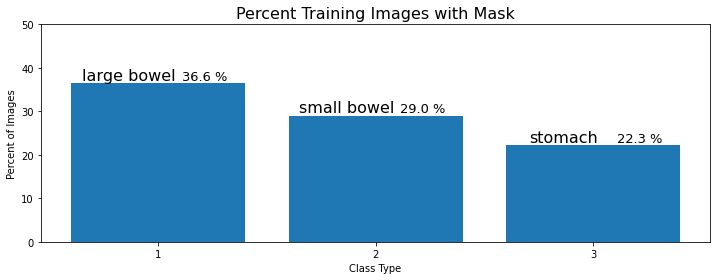

In [23]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean(train_df.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect,lbl in zip(bar,labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50))
plt.show()

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


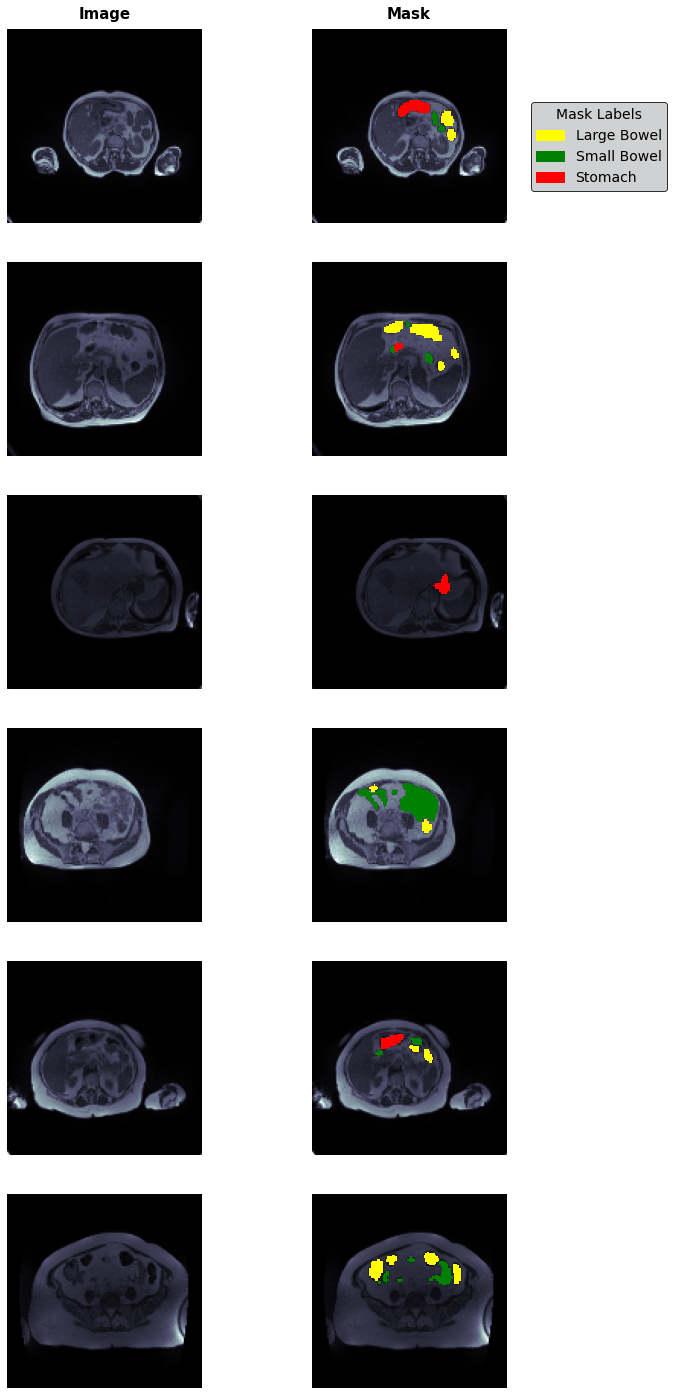

In [24]:
# SAMPLES
Masks = list(train_df[train_df['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(train_df[train_df['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(train_df[train_df['stomach']!=''].sample(BATCH_SIZE*3).index)


# DATA GENERATOR
View_batches = DataGenerator(train_df[train_df.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

Training

In [25]:
# Group by case id
skf = StratifiedGroupKFold(n_splits = n_splits, shuffle=True, random_state = 42)
for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df['count'], groups=train_df['case']),1):
  train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(np.uint8)

train_ids = train_df[train_df["fold"]!=fold_selected].index
valid_ids = train_df[train_df["fold"]!=fold_selected].index

X_train = train_df[train_df.index.isin(train_ids)]
X_valid = train_df[train_df.index.isin(valid_ids)]

train_df.groupby('fold').size()

fold
1    8160
2    6080
3    8192
4    9152
5    6624
dtype: int64

In [26]:
train_df.groupby(['fold','count'])['id'].count()

fold  count
1     0        4857
      1         475
      2        2155
      3         673
2     0        3412
      1         294
      2        1793
      3         581
3     0        4622
      1         537
      2        2278
      3         755
4     0        5160
      1         744
      2        2596
      3         652
5     0        3718
      1         396
      2        2012
      3         498
Name: id, dtype: int64

In [27]:
train_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)

In [28]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

### U-Net Model

In [29]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
! pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-an0pv3i5
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-an0pv3i5
  Running command git submodule update --init --recursive -q


In [31]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [32]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef]) #binary_crossentropy
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 64)   256         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 64, 64, 64)   0           ['stem_bn[0][0]']            

In [33]:
model_path = '/content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg/model_122022.h5'

In [34]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1)
]

In [ ]:
history = model.fit(
    train_generator, 
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = callbacks,
    workers = 4,
    use_multiprocessing = False
)

Epoch 1/10
2008/2008 [==============================] - ETA: 0s - loss: 0.2353 - dice_coef: 0.5764 - iou_coef: 0.3913
Epoch 1: val_loss improved from inf to 0.33365, saving model to /content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg/model_122022.h5
2008/2008 [==============================] - 5294s 3s/step - loss: 0.2353 - dice_coef: 0.5764 - iou_coef: 0.3913 - val_loss: 0.3337 - val_dice_coef: 0.3722 - val_iou_coef: 0.5916 - lr: 0.0010
Epoch 2/10
2008/2008 [==============================] - ETA: 0s - loss: 0.1256 - dice_coef: 0.7718 - iou_coef: 0.6881
Epoch 2: val_loss improved from 0.33365 to 0.23223, saving model to /content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg/model_122022.h5
2008/2008 [==============================] - 956s 476ms/step - loss: 0.1256 - dice_coef: 0.7718 - iou_coef: 0.6881 - val_loss: 0.2322 - val_dice_coef: 0.5551 - val_iou_coef: 0.7595 - lr: 0.0010
Epoch 3/10
2008/2008 [==============================] - ETA: 0s - loss: 0.

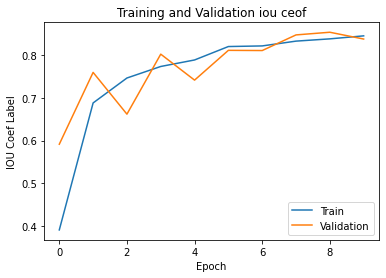

In [ ]:
iou_coef = history.history['iou_coef']
val_iou_coef = history.history['val_iou_coef']

plt.figure()
plt.plot(history.epoch, iou_coef)
plt.plot(history.epoch, val_iou_coef)
plt.title('Training and Validation iou ceof')
plt.xlabel('Epoch')
plt.ylabel('IOU Coef Label')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

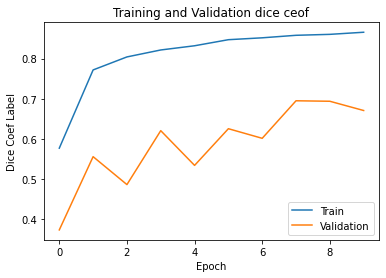

In [ ]:
dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

plt.figure()
plt.plot(history.epoch, dice_coef)
plt.plot(history.epoch, val_dice_coef)
plt.title('Training and Validation dice ceof')
plt.xlabel('Epoch')
plt.ylabel('Dice Coef Label')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

Predict from validation set

In [35]:
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
}

model = load_model('/content/drive/MyDrive/Projects/Image_Segmentation/gi_tract_image_seg/model_122022.h5', custom_objects = custom_objects)

In [36]:
pred_batches = DataGenerator(X_valid.iloc[210:218,:], batch_size=1, subset="train", shuffle=False)
preds = model.predict_generator(pred_batches, verbose=1)

<ipython-input-36-b6e5124ce352>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(pred_batches, verbose=1)


8/8 [==============================] - 7s 36ms/step


In [37]:
def predict(batch, imgs = 8):
  Threshold = 0.5

  #visualizing
  fig = plt.figure(figsize = (10,25))
  gs = gridspec.GridSpec(nrows=8, ncols=3)
  colors = ['yellow','green','red']
  labels = ['Large Bowel','Small Bowel','Stomach']
  patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

  cmap1 = mpl.colors.ListedColormap(colors[0])
  cmap2 = mpl.colors.ListedColormap(colors[1])
  cmap3 = mpl.colors.ListedColormap(colors[2])

  for i in range(imgs):
    images, mask = batch[i]
    sample_img = images[0,:,:,0]
    mask1 = mask[0,:,:,0]
    mask2 = mask[0,:,:,1]
    mask3 = mask[0,:,:,2]

    pre = preds[i]
    predict1 = pre[:,:,0]
    predict2 = pre[:,:,1]
    predict3 = pre[:,:,2]

    predict1 = (predict1 > Threshold).astype(np.float32)
    predict2 = (predict2 > Threshold).astype(np.float32)
    predict3 = (predict3 > Threshold).astype(np.float32)

    predict1 = (predict1 > Threshold).astype(np.float32)
    predict2 = (predict2 > Threshold).astype(np.float32)
    predict3 = (predict3 > Threshold).astype(np.float32)

    ax0 = fig.add_subplot(gs[i,0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)

    ax1 = fig.add_subplot(gs[i,1])
    ax1.set_title("Mask", fontsize=12, y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1 == False, mask1), cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2 == False, mask2), cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3 == False, mask3), cmap=cmap3, alpha=1)

    ax2 = fig.add_subplot(gs[i,2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1==False, predict1), cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2==False, predict2), cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3==False, predict3), cmap=cmap3, alpha=1)

    _ = [ax.set_axis_off() for ax in [ax0, ax1, ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2,l3]]
    plt.legend(handles = patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize=12, title='Mask Labels', title_fontsize=12, edgecolor="black", facecolor="#c5C6c7")

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


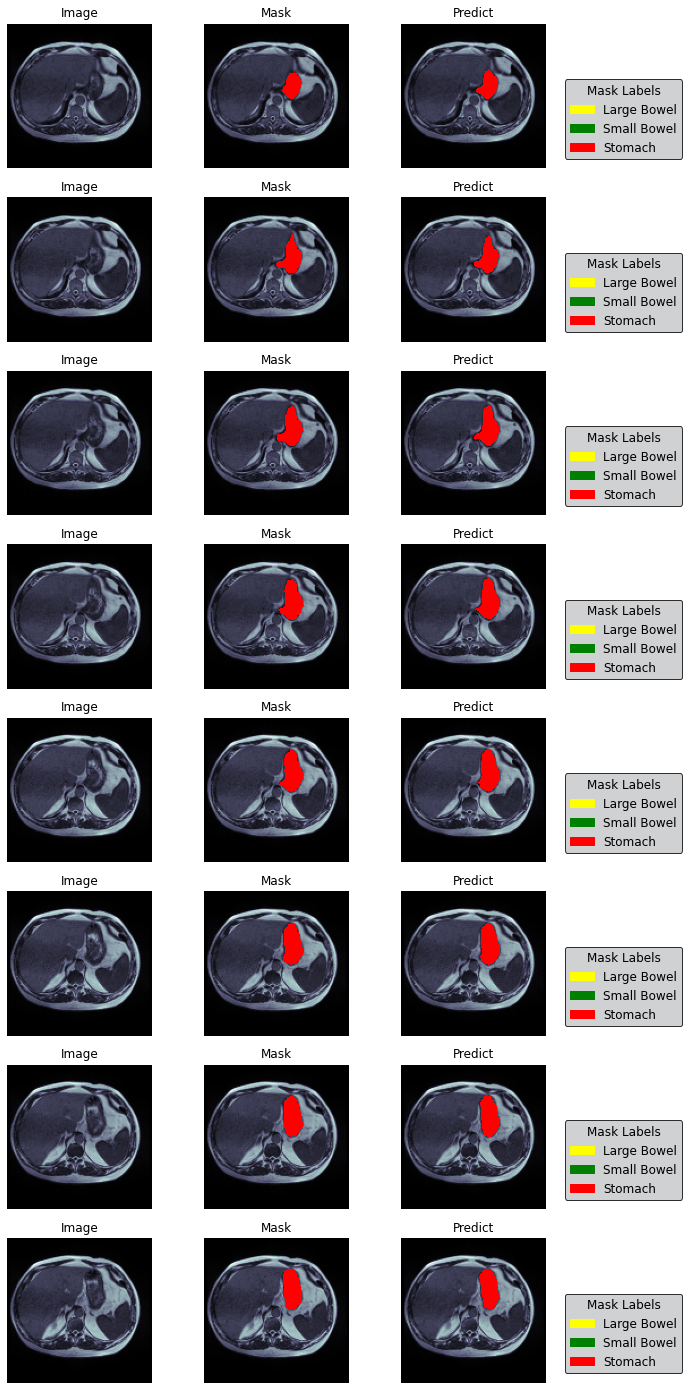

In [38]:
predict(pred_batches, 8)

Predicting on Test set.

In [39]:
test_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)

for i in range(num_batches):
  preds = model.predict(test_batches[i], verbose=0) #shape:(16,im_height, im_width,3)

  # Rle encode
  for j in range(BATCH_SIZE):
    for k in range(3):
      pred_img = cv2.resize(preds[j,:,:,k],(test_df.loc[i*BATCH_SIZE + j, "width"], test_df.loc[i * BATCH_SIZE + j, "height"]), interpolation=cv2.INTER_NEAREST) #resize prob to original shape
      pred_img = (pred_img>0.5).astype(dtype='uint8') #classify
      results.loc[3*(i*BATCH_SIZE+j)+k,'predicted'] = rle_encode(pred_img)

In [40]:
results.sample(20)

,id,class,predicted
55,case123_day20_slice_0019,small_bowel,
295,case123_day20_slice_0099,small_bowel,20149 6 20415 6 20677 12 20943 12 21155 10 211...
180,case123_day20_slice_0061,large_bowel,
188,case123_day20_slice_0063,stomach,
447,case123_day22_slice_0006,large_bowel,
380,case123_day20_slice_0127,stomach,
427,case123_day20_slice_0143,small_bowel,
134,case123_day20_slice_0045,stomach,
34,case123_day20_slice_0012,small_bowel,
363,case123_day20_slice_0122,large_bowel,
